Github link: https://github.com/nmc-33/NaturalDisasterRNN

Step 1: Brief Description of the problem and data

This project is a natural language processing and binary class classification project. Based on the text of the tweets, the goal is to build a model that will be able to determine whether a tweet belongs to one of two classes - related to a natural disaster or unrelated to a natural disaster.

The train dataset contains 7503 tweets, with labels. The test dataset is unlabelled, with 3243 tweets. Additional data about keyword and location is available for some tweets. The tweets are formatted as strings.

Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(train_df.info())
print(train_df['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    4342
1    3271
Name: count, dtype: int64


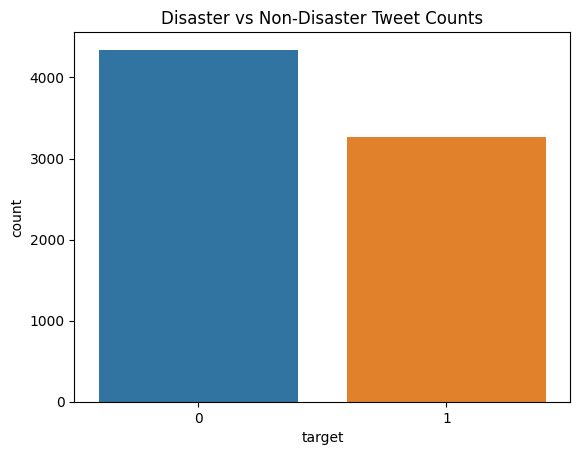

In [3]:
sns.countplot(data=train_df, x='target')
plt.title('Disaster vs Non-Disaster Tweet Counts')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

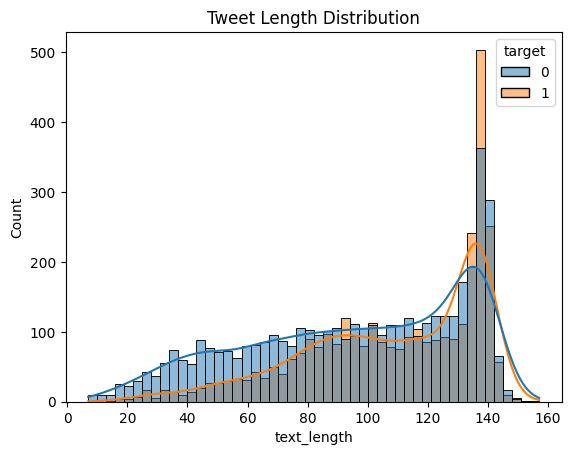

In [4]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.show()

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return " ".join([word for word in text.split() if word not in stop_words])

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Step 3: Model Architecture

For this project, the primary architecture that I will be using a recurrent neural network, with an embedding layer and a bidirectional LSTM layer. Only 1 birdirectional LSTM layer will be used to prevent overfitting. 

One key advantage of this framework come from the embedding. I will be using GloVe embedding. It creates vectors by analyzing the words that frequently occur along with a specific word. Essentially, words generally appear in similar contexts, so packaging information about a words likely context into a vector will help best capture the meaning of the word in the context of the tweet. Glove works by creating a co-occurence matrix, and factorizing it to generate vectors for each word. These vectors allow the words to convey the semantic relationship the word has in context of its use. 

Bidirectional LSTM is used to help parse the context of tweets, where the grammar and language used is generally less formal, so having both sides of a sentence to use help it to more accurately capture meaning.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

embedding_index = {}
with open("/kaggle/input/glove-twitter-27b-100d-txt/glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])  
sequences = tokenizer.texts_to_sequences(train_df['text'])
word_index = tokenizer.word_index

max_sequence_length = 100 
train_padded = pad_sequences(sequences, maxlen=max_sequence_length)

train_labels = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=42)

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

2025-04-21 02:17:00.750737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745201821.008655      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745201821.075550      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
lstm_units = [32, 64, 128, 256]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [1e-3, 1e-4, 1e-5]
results = []

for units in lstm_units:
    for dropout in dropout_rates:
        for lr in learning_rates:
            model = Sequential()
            model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                                output_dim=embedding_matrix.shape[1], 
                                weights=[embedding_matrix], 
                                trainable=False))
            model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
            model.add(Dropout(dropout))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
            history = model.fit(X_train, y_train, 
                                epochs=5, batch_size=64, 
                                validation_data=(X_val, y_val), 
                                verbose=0)
            val_accuracy = history.history['val_accuracy'][-1]
            results.append({
                'lstm_units': units,
                'dropout': dropout,
                'learning_rate': lr,
                'val_accuracy': val_accuracy
            })

results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['val_accuracy'].idxmax()]
print(f"Best Hyperparameters: {best_result}")


    lstm_units  dropout  learning_rate  val_accuracy
0           32      0.2        0.00100      0.809586
1           32      0.2        0.00010      0.797768
2           32      0.2        0.00001      0.574524
3           32      0.3        0.00100      0.814839
4           32      0.3        0.00010      0.802364
5           32      0.3        0.00001      0.573867
6           32      0.4        0.00100      0.814839
7           32      0.4        0.00010      0.801051
8           32      0.4        0.00001      0.566645
9           64      0.2        0.00100      0.814183
10          64      0.2        0.00010      0.808930
11          64      0.2        0.00001      0.598162
12          64      0.3        0.00100      0.797768
13          64      0.3        0.00010      0.805647
14          64      0.3        0.00001      0.654629
15          64      0.4        0.00100      0.825345
16          64      0.4        0.00010      0.811556
17          64      0.4        0.00001      0.

Step 5: Conclusion

The key takeaway from this process was that although a relatively simple RNN with more robust embedding and robust internals works for fitting, it's likely not robust enough. The models fit here gave a best accuracy of 0.82. Although this is good for a lot of applications, given the fast training time and shallow depth of the model, given the critical application to natural disasters, higher fideltity is really necessary for this process. 

Increasing the lstm units helped with fidelity, as did lowering the learning rate to an extent. The lower learning rates tested, 0.0001 and 0.001 have roughly similar performance. Dropout got better to a point, and then fidelity began to decrease, with best performance when droput = 0.3. 

Future improvements to model would using more robust embeddings, using simpler embeddings and layers, with more of them, or a GRU based architecture.

In [10]:
best_units = int(best_result['lstm_units'])
best_dropout = float(best_result['dropout'])
best_lr = float(best_result['learning_rate'])

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Bidirectional(LSTM(units=best_units, return_sequences=False)))
model.add(Dropout(best_dropout))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_padded)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predicted_labels
})

submission.to_csv('submission.csv', index=False)


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6234 - loss: 0.6454
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7819 - loss: 0.4751
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7942 - loss: 0.4625
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8127 - loss: 0.4247
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8065 - loss: 0.4283
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [12]:
submission.to_csv('submission.csv', index=False)